# CNNs

At the end of this exercise you will know how to:
- construct a CNN image classification pipeline from scratch, based on the [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) PyTorch tutorial
- use a pretrained CNN model for image classification, based on the [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) by PyTorch

We will keep this notebook as tight as possible as many of the questions you might have are already answered in these excellent PyTorch tutorials. Our focus will be on the nitty-gritty details, which are not explained in depth in the tutorials.

> One further helpful PyTorch resource is the official [cheat sheet](https://github.com/pytorch/tutorials/blob/main/beginner_source/PyTorch%20Cheat.md).

In [20]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.tensorboard import SummaryWriter

cudnn.benchmark = True
plt.ion()   # interactive mode

# Load the TensorBoard notebook extension for logging training runs
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Training a Classifier

We will be working with the Cifar10 dataset, which is probably the second best known classification dataset just after Mnist and just before ImageNet. It consists of 60,000 RGB images of shape 3x32x32 from 10 different classes with 6000 images per class. The python dataset requires around 160 MB space.

In [21]:
# the transform is a preprocessing step over the data before feeding it to the model.
# The `ToTensor` transform converts the PIL image to a tensor with values in the range
# [0, 1]. The `Normalize` transform applies input normalization which you have seen in 
# the "Tricks of Optimization" lecture. 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# if you don't use the `download=True` argument, the data will be downloaded in the
# root directory, if it is not already there.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Now, we can look at one random batch.

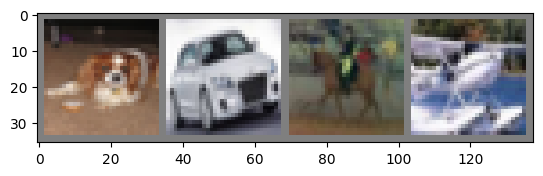

dog   car   horse plane
Shapes of images: torch.Size([4, 3, 32, 32]) and labels: torch.Size([4])


In [23]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
# first make an iterator over the training data and then get the `next` batch
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
# print shapes
print(f'Shapes of images: {images.shape} and labels: {labels.shape}')


We are ready to define our first CNN

In [24]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

To have a trainig loop we are just missing the loss ("criterion") and optimizer

In [25]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


Let's train this model

In [29]:
writer = SummaryWriter('runs/cifar10_experiment_1')

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            writer.add_scalar('train/loss', running_loss / 2000, epoch * len(trainloader) + i )
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
writer.close()

[1,  2000] loss: 1.486
[1,  4000] loss: 1.424
[1,  6000] loss: 1.403
[1,  8000] loss: 1.362
[1, 10000] loss: 1.342
[1, 12000] loss: 1.316
[2,  2000] loss: 1.225
[2,  4000] loss: 1.237
[2,  6000] loss: 1.219
[2,  8000] loss: 1.201
[2, 10000] loss: 1.192
[2, 12000] loss: 1.203
Finished Training


In [13]:
writer.close()


In [28]:
%tensorboard --logdir 'runs/cifar10_experiment_1'

Reusing TensorBoard on port 6006 (pid 66592), started 0:00:02 ago. (Use '!kill 66592' to kill it.)

Get a prediction over one of the test batches

In [31]:
# get test sample
dataiter = iter(testloader)
images, labels = next(dataiter)

# evaluate model on test input
outputs = net(images)

# make predictions
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


Predicted:  cat   plane truck plane
GroundTruth:  cat   ship  ship  plane


Evaluate full accuracy

In [32]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 55 %


Or evaluating the accuracy per class

In [33]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 66.4 %
Accuracy for class: car   is 44.2 %
Accuracy for class: bird  is 28.2 %
Accuracy for class: cat   is 24.7 %
Accuracy for class: deer  is 45.6 %
Accuracy for class: dog   is 66.4 %
Accuracy for class: frog  is 77.0 %
Accuracy for class: horse is 71.6 %
Accuracy for class: ship  is 48.8 %
Accuracy for class: truck is 78.9 %


Let's see how to achieve GPU training

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [35]:
!nvidia-smi

Wed Jan 18 17:22:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P8     5W /  N/A |   1256MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
# the trick is to move the model as well as the data to the GPU
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

writer = SummaryWriter('runs/cifar10_experiment_1')

for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # the only difference is that we move the data to the GPU here
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    
            writer.add_scalar('train/loss', running_loss /
                              2000, epoch * len(trainloader) + i)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
writer.close()


[1,  2000] loss: 2.201
[1,  4000] loss: 1.878
[1,  6000] loss: 1.699
[1,  8000] loss: 1.603
[1, 10000] loss: 1.553
[1, 12000] loss: 1.487
[2,  2000] loss: 1.429
[2,  4000] loss: 1.398
[2,  6000] loss: 1.372
[2,  8000] loss: 1.348
[2, 10000] loss: 1.325
[2, 12000] loss: 1.304
Finished Training


## Pretraining

In [37]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [38]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


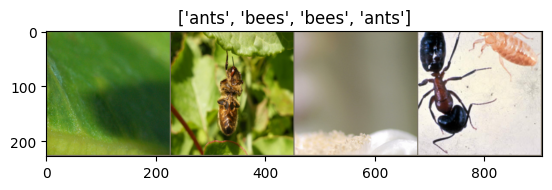

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


Finetuning a CNN

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


/home/artur/Dropbox/ARTUR_Archiv/PhD/Lehre/SciML22-23/jupyter_book/SciML22-23/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/artur/Dropbox/ARTUR_Archiv/PhD/Lehre/SciML22-23/jupyter_book/SciML22-23/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
train Loss: 0.5893 Acc: 0.7172
val Loss: 0.2793 Acc: 0.9085

Epoch 1/1
----------
train Loss: 0.4084 Acc: 0.8402
val Loss: 0.2895 Acc: 0.8954

Training complete in 0m 27s
Best val Acc: 0.908497


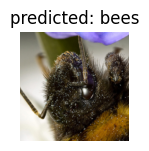

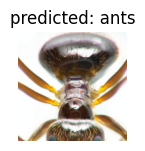

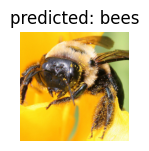

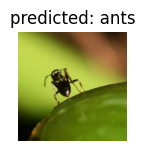

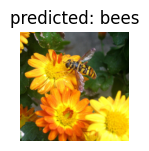

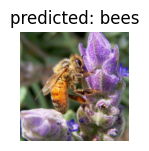

In [13]:
visualize_model(model_ft)

Fixed feature extractor

In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=2)


Epoch 0/1
----------
train Loss: 0.6143 Acc: 0.7008
val Loss: 0.2256 Acc: 0.9346

Epoch 1/1
----------
train Loss: 0.4605 Acc: 0.7828
val Loss: 0.1802 Acc: 0.9477

Training complete in 0m 12s
Best val Acc: 0.947712


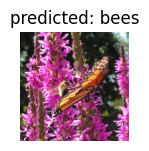

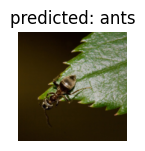

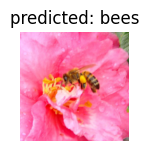

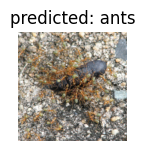

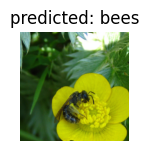

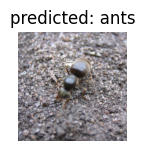

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()
